In [1]:
import os
import time
import numpy as np
from scipy.special import softmax
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import statsmodels.api as sm

os.getcwd()

'/Users/socialai/Documents/state_punishment_May6/examples/state_punishment/notebooks'

In [2]:
# utils

def plot_quadratic_curve(x, y, ylabel, xlabel='Punishment level'):
    # Fit a quadratic curve (degree=2) to the data
    coeffs = np.polyfit(x, y, deg=2)
    poly_fn = np.poly1d(coeffs)  # Create a polynomial function

    # Generate smooth x-values and corresponding fitted y-values
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = poly_fn(x_fit)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color='blue', s=1)
    plt.plot(x_fit, y_fit, label='Fitted Quadratic Curve', color='red')
    plt.title('Scatter Plot with Fitted Quadratic Curve')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# util functions

def replace_entity_appearance(env, new, entities):
    """
    Replace the appearance of an entity in the environment.
    """
    # get new entity appearance
    for entity in entities:
        if entity.type == new:
            new_appearance = entity.appearance
            break
    # find and replace the old entity appearance
    for loc, entity in np.ndenumerate(env.world):
        if entity.type != new and entity.type != 'wall' and entity.type != 'emptyobject':
            entity.appearance = new_appearance

Probe test

In [21]:
# no visualization, run_test func
# composite visualization

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #


from agentarium.logging_utils import GameLogger
from agentarium.primitives import Entity
from examples.state_punishment.agents import Agent
from examples.state_punishment.env import state_punishment
from examples.state_punishment.state_sys import state_sys
from examples.state_punishment.utils import (create_agents, create_entities, create_models,
                                init_log, load_config, save_config_backup)
from IPython.display import clear_output
from agentarium.models import human_player

from matplotlib import pyplot as plt
import random
import argparse
from copy import deepcopy
import torch

def test_resource_valuation(
        seed,
        clear_world, 
        max_turns, 
        state_punishment_prob,
        entity_to_keep,
        model_prefix,
        config_path,
        algo
        ):
    config_path = config_path

    cfg = load_config(argparse.Namespace(config=config_path))
    cfg.env.prob.respawn_rate = 0.0
    cfg.experiment.max_turns = max_turns
    cfg.seed = seed
    clear_world = clear_world
    cfg.algo = algo

    # set seed 
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed_all(cfg.seed)

    models = create_models(cfg)
   
    agents = create_agents(cfg, models)
    entities = create_entities(cfg)
    envs = []
    for i in range(len(agents)):
        envs.append(
            state_punishment(cfg, [agents[i]], deepcopy(entities))
        )
    # replace entity appearance
    for env_isx, env in enumerate(envs):
        replace_entity_appearance(
            env, 
            entity_to_keep, 
            entities
        )


    for ixs, agent in enumerate(agents):
        if agent.ixs > -1:
            agent.model.load(
                f'../models/checkpoints/{model_prefix}_agent{agent.ixs}_iRainbowModel.pkl'
            )
        else:
            agent.model = human_player.ModelHumanPlayer(
                action_space=4, 
                state_size = cfg.model.iqn.parameters.state_size, 
                extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
                memory_size=1, 
                name=f'human {ixs}')


    for epoch in range(1):
        # Reset the environment at the start of each epoch
        for env_ixs, env in enumerate(envs):
            env.reset(state_mode='composite')
            if env_ixs in clear_world:
                env.clear_world(keep_agents=True)
            env.cache['harm'] = [0 for _ in range(len(agents))]

        random.shuffle(agents)
    
        fixed_prob_dict = {'Gem': cfg.state_sys.prob_list.Gem,
                            'Coin': cfg.state_sys.prob_list.Coin,
                            'Bone': cfg.state_sys.prob_list.Bone}
        
        # initialize state system
        state_entity = state_sys(
                cfg.state_sys.init_prob, 
                fixed_prob_dict,
                cfg.state_sys.magnitude, 
                cfg.state_sys.taboo,
                cfg.state_sys.resource_punishment_is_ambiguous,
                cfg.state_sys.potential_taboo,
                cfg.state_sys.only_punish_taboo,
                cfg = cfg
                )
        

        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]
        vote_for = [0 for _ in range(len(agents))]
        vote_against = [0 for _ in range(len(agents))]
        action_values_lst = [[] for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            for env in envs:
                entities = env.get_entities_for_transition()
                # Entity transition
                for entity in entities:
                    entity.transition(env)


            # Agent transition
            for ixs, agent in enumerate(agents):

                # manually set state
                if state_punishment_prob is not None:
                    state_entity.prob = state_punishment_prob

                (state, action, reward, next_state, done_, action_values) = agent.transition(
                        envs[agent.ixs], 
                        state_entity, 
                        'certain', 
                        action_mode=cfg.action_mode,
                        state_is_composite=cfg.state_mode=='composite',
                        envs=envs,
                        is_eval=True
                        )

                action_values_lst[agent.ixs].append(action_values)
                # record vote
                if action == 4:
                    vote_for[agent.ixs] += 1
                elif action == 5:
                    vote_against[agent.ixs] += 1

            
                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                agent.add_memory(state, action, reward, done)

                game_points[agent.ixs] += reward

    return vote_for, vote_against, action_values_lst


In [24]:
# no visualization, run_test func
# composite visualization

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array, composite_visualization
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse
from copy import deepcopy
import torch

def run_test(
        seed,
        clear_world, 
        max_turns, 
        state_punishment_prob,
        model_prefix,
        config_path,
        algo,
        clear_entities = None
        ):
    config_path = config_path

    cfg = load_config(argparse.Namespace(config=config_path))
    cfg.env.prob.respawn_rate = 0.0
    cfg.experiment.max_turns = max_turns
    cfg.seed = seed
    clear_world = clear_world
    cfg.algo = algo

    # set seed 
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed_all(cfg.seed)

    models = create_models(cfg)
    agents = create_agents(cfg, models)
    entities = create_entities(cfg)
    envs = []
    for i in range(len(agents)):
        envs.append(
            state_punishment(cfg, [agents[i]], deepcopy(entities))
        )


    for ixs, agent in enumerate(agents):
        if agent.ixs > -1:
            agent.model.load(
                f'../models/checkpoints/{model_prefix}_agent{agent.ixs}_iRainbowModel.pkl'
            )
        else:
            agent.model = human_player.ModelHumanPlayer(
                action_space=4, 
                state_size = cfg.model.iqn.parameters.state_size, 
                extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
                memory_size=1, 
                name=f'human {ixs}')


    for epoch in range(1):
        # Reset the environment at the start of each epoch
        for env_ixs, env in enumerate(envs):
            env.reset(state_mode='composite')
            if env_ixs in clear_world:
                env.clear_world(keep_agents=True)
            env.cache['harm'] = [0 for _ in range(len(agents))]

        random.shuffle(agents)
    
        fixed_prob_dict = {'Gem': cfg.state_sys.prob_list.Gem,
                            'Coin': cfg.state_sys.prob_list.Coin,
                            'Bone': cfg.state_sys.prob_list.Bone}
        
        # initialize state system
        state_entity = state_sys(
                cfg.state_sys.init_prob, 
                fixed_prob_dict,
                cfg.state_sys.magnitude, 
                cfg.state_sys.taboo,
                cfg.state_sys.resource_punishment_is_ambiguous,
                cfg.state_sys.potential_taboo,
                cfg.state_sys.only_punish_taboo,
                cfg = cfg
                )
        

        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]
        vote_for = [0 for _ in range(len(agents))]
        vote_against = [0 for _ in range(len(agents))]
        action_values_lst = [[] for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            for env in envs:
                entities = env.get_entities_for_transition()
                # Entity transition
                for entity in entities:
                    entity.transition(env)


            # Agent transition
            for ixs, agent in enumerate(agents):

                # manually set state
                if state_punishment_prob is not None:
                    state_entity.prob = state_punishment_prob

                (state, action, reward, next_state, done_, action_values) = agent.transition(
                        envs[agent.ixs], 
                        state_entity, 
                        'certain', 
                        action_mode=cfg.action_mode,
                        state_is_composite=cfg.state_mode=='composite',
                        envs=envs,
                        is_eval=True
                        )

                action_values_lst[agent.ixs].append(action_values)
                # record vote
                if action == 4:
                    vote_for[agent.ixs] += 1
                elif action == 5:
                    vote_against[agent.ixs] += 1

            
                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                agent.add_memory(state, action, reward, done)

                game_points[agent.ixs] += reward

    return vote_for, vote_against, action_values_lst


In [20]:
model_name = "Study1_experiment_cond_v3_one_voter_stacked_view_simple_actions_memory_issue_solved_3agents_respawn_0.04_s1_r1_seed3"

In [23]:
# valuation of each resource
resources = ['A', 'B', 'C', 'D', 'E']
v_vals_mean = {key: [] for key in resources}
probs = {key: [] for key in resources}

for trial in trange(25):
    for resource in resources:
        for prob in np.arange(0, 1.1, 0.1):
            _, _, action_values_lst = test_resource_valuation(
                seed=trial,
                clear_world=[], 
                max_turns=1, 
                state_punishment_prob=prob,
                entity_to_keep=resource,
                model_prefix=model_name,
                algo='iqn',
                config_path='../configs/config_with_vote_composite_study1_probe_test.yaml',
            )
            action_values_lst = [val[0].mean() for val in action_values_lst]
            v_vals_mean[resource].append(torch.stack(action_values_lst).numpy().mean())
            probs[resource].append(prob)

  0%|          | 0/25 [00:00<?, ?it/s]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


  4%|▍         | 1/25 [00:16<06:31, 16.33s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


  8%|▊         | 2/25 [00:32<06:14, 16.28s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 12%|█▏        | 3/25 [00:48<05:56, 16.22s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 16%|█▌        | 4/25 [01:05<05:45, 16.44s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 20%|██        | 5/25 [01:21<05:26, 16.34s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 24%|██▍       | 6/25 [01:38<05:13, 16.51s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 28%|██▊       | 7/25 [01:55<04:57, 16.55s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 32%|███▏      | 8/25 [02:11<04:42, 16.61s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 36%|███▌      | 9/25 [02:28<04:25, 16.62s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 40%|████      | 10/25 [02:45<04:08, 16.60s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 44%|████▍     | 11/25 [03:01<03:51, 16.56s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 48%|████▊     | 12/25 [03:17<03:34, 16.49s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 52%|█████▏    | 13/25 [03:34<03:18, 16.52s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 56%|█████▌    | 14/25 [03:51<03:02, 16.62s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 60%|██████    | 15/25 [04:07<02:43, 16.35s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 64%|██████▍   | 16/25 [04:22<02:25, 16.22s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 68%|██████▊   | 17/25 [04:39<02:10, 16.31s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 72%|███████▏  | 18/25 [04:55<01:54, 16.32s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 76%|███████▌  | 19/25 [05:12<01:38, 16.41s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 80%|████████  | 20/25 [05:28<01:22, 16.44s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 84%|████████▍ | 21/25 [05:45<01:05, 16.33s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 88%|████████▊ | 22/25 [06:01<00:48, 16.32s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 92%|█████████▏| 23/25 [06:17<00:32, 16.23s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


 96%|█████████▌| 24/25 [06:33<00:16, 16.27s/it]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


100%|██████████| 25/25 [06:50<00:00, 16.44s/it]


In [109]:
len(v_vals_mean['E']), len(probs)

(110, 553)

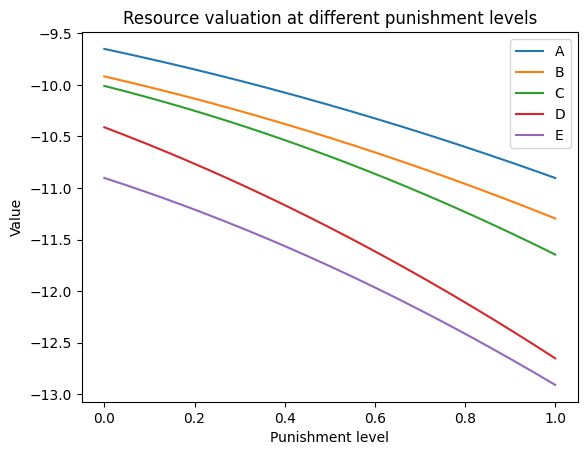

In [25]:
# plot 
for resource in resources:
    # plot_quadratic_curve(probs[resource], v_vals_mean[resource], ylabel=f'Value of {resource}')
    x = probs[resource]
    y = v_vals_mean[resource]
    coeffs = np.polyfit(x, y, deg=2)
    poly_fn = np.poly1d(coeffs)  # Create a polynomial function

    # Generate smooth x-values and corresponding fitted y-values
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = poly_fn(x_fit)
    plt.plot(x_fit, y_fit, label=resource)
plt.xlabel('Punishment level')
plt.ylabel('Value')
plt.title('Resource valuation at different punishment levels')
plt.legend()
plt.show()

In [31]:
# state punishment level ~ state value estimation
v_vals_mean = []
probs = []
for seed in trange(50):
    for prob in np.arange(0, 1.1, 0.1):
        _, _, action_values_lst = run_test(
            seed=seed,
            clear_world=[], 
            max_turns=1, 
            state_punishment_prob=prob,
            model_prefix=model_name,
            algo='iqn',
            config_path='../configs/config_with_vote_composite_study1_probe_test.yaml',
            )
        action_values_lst = [val[0].mean() for val in action_values_lst]
        v_vals_mean.append(torch.stack(action_values_lst).numpy().mean())
        probs.append(prob)
# plt.plot(np.arange(0, 1.1, 0.1), v_vals_mean, 'o-')

  0%|          | 0/50 [00:00<?, ?it/s]

here
here
here
here
here
here
here
here
here
here
here


  2%|▏         | 1/50 [00:03<02:52,  3.52s/it]

here
here
here
here
here
here
here
here
here
here
here


  4%|▍         | 2/50 [00:06<02:36,  3.27s/it]

here
here
here
here
here
here
here
here
here
here
here


  6%|▌         | 3/50 [00:10<02:41,  3.43s/it]

here
here
here
here
here
here
here
here
here
here
here


  8%|▊         | 4/50 [00:13<02:33,  3.34s/it]

here
here
here
here
here
here
here
here
here
here
here


 10%|█         | 5/50 [00:16<02:32,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 12%|█▏        | 6/50 [00:20<02:26,  3.32s/it]

here
here
here
here
here
here
here
here
here
here
here


 14%|█▍        | 7/50 [00:23<02:19,  3.24s/it]

here
here
here
here
here
here
here
here
here
here
here


 16%|█▌        | 8/50 [00:26<02:19,  3.33s/it]

here
here
here
here
here
here
here
here
here
here
here


 18%|█▊        | 9/50 [00:29<02:12,  3.23s/it]

here
here
here
here
here
here
here
here
here
here
here


 20%|██        | 10/50 [00:33<02:14,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 22%|██▏       | 11/50 [00:36<02:07,  3.27s/it]

here
here
here
here
here
here
here
here
here
here
here


 24%|██▍       | 12/50 [00:40<02:10,  3.42s/it]

here
here
here
here
here
here
here
here
here
here
here


 26%|██▌       | 13/50 [00:43<02:02,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 28%|██▊       | 14/50 [00:46<01:59,  3.33s/it]

here
here
here
here
here
here
here
here
here
here
here


 30%|███       | 15/50 [00:49<01:55,  3.31s/it]

here
here
here
here
here
here
here
here
here
here
here


 32%|███▏      | 16/50 [00:53<01:57,  3.45s/it]

here
here
here
here
here
here
here
here
here
here
here


 34%|███▍      | 17/50 [00:56<01:49,  3.32s/it]

here
here
here
here
here
here
here
here
here
here
here


 36%|███▌      | 18/50 [00:59<01:45,  3.29s/it]

here
here
here
here
here
here
here
here
here
here
here


 38%|███▊      | 19/50 [01:03<01:44,  3.36s/it]

here
here
here
here
here
here
here
here
here
here
here


 40%|████      | 20/50 [01:06<01:39,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 42%|████▏     | 21/50 [01:10<01:37,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 44%|████▍     | 22/50 [01:13<01:32,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 46%|████▌     | 23/50 [01:16<01:27,  3.23s/it]

here
here
here
here
here
here
here
here
here
here
here


 48%|████▊     | 24/50 [01:19<01:27,  3.35s/it]

here
here
here
here
here
here
here
here
here
here
here


 50%|█████     | 25/50 [01:22<01:20,  3.22s/it]

here
here
here
here
here
here
here
here
here
here
here


 52%|█████▏    | 26/50 [01:26<01:18,  3.25s/it]

here
here
here
here
here
here
here
here
here
here
here


 54%|█████▍    | 27/50 [01:29<01:14,  3.24s/it]

here
here
here
here
here
here
here
here
here
here
here


 56%|█████▌    | 28/50 [01:32<01:13,  3.33s/it]

here
here
here
here
here
here
here
here
here
here
here


 58%|█████▊    | 29/50 [01:36<01:13,  3.52s/it]

here
here
here
here
here
here
here
here
here
here
here


 60%|██████    | 30/50 [01:39<01:07,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 62%|██████▏   | 31/50 [01:43<01:02,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 64%|██████▍   | 32/50 [01:46<01:02,  3.45s/it]

here
here
here
here
here
here
here
here
here
here
here


 66%|██████▌   | 33/50 [01:49<00:56,  3.32s/it]

here
here
here
here
here
here
here
here
here
here
here


 68%|██████▊   | 34/50 [01:52<00:52,  3.25s/it]

here
here
here
here
here
here
here
here
here
here
here


 70%|███████   | 35/50 [01:57<00:53,  3.54s/it]

here
here
here
here
here
here
here
here
here
here
here


 72%|███████▏  | 36/50 [02:00<00:48,  3.45s/it]

here
here
here
here
here
here
here
here
here
here
here


 74%|███████▍  | 37/50 [02:04<00:46,  3.56s/it]

here
here
here
here
here
here
here
here
here
here
here


 76%|███████▌  | 38/50 [02:07<00:40,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 78%|███████▊  | 39/50 [02:11<00:38,  3.54s/it]

here
here
here
here
here
here
here
here
here
here
here


 80%|████████  | 40/50 [02:14<00:33,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 82%|████████▏ | 41/50 [02:17<00:30,  3.39s/it]

here
here
here
here
here
here
here
here
here
here
here


 84%|████████▍ | 42/50 [02:20<00:26,  3.32s/it]

here
here
here
here
here
here
here
here
here
here
here


 86%|████████▌ | 43/50 [02:24<00:23,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 88%|████████▊ | 44/50 [02:27<00:20,  3.47s/it]

here
here
here
here
here
here
here
here
here
here
here


 90%|█████████ | 45/50 [02:31<00:16,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 92%|█████████▏| 46/50 [02:34<00:13,  3.29s/it]

here
here
here
here
here
here
here
here
here
here
here


 94%|█████████▍| 47/50 [02:37<00:09,  3.27s/it]

here
here
here
here
here
here
here
here
here
here
here


 96%|█████████▌| 48/50 [02:41<00:06,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 98%|█████████▊| 49/50 [02:44<00:03,  3.31s/it]

here
here
here
here
here
here
here
here
here
here
here


100%|██████████| 50/50 [02:47<00:00,  3.35s/it]


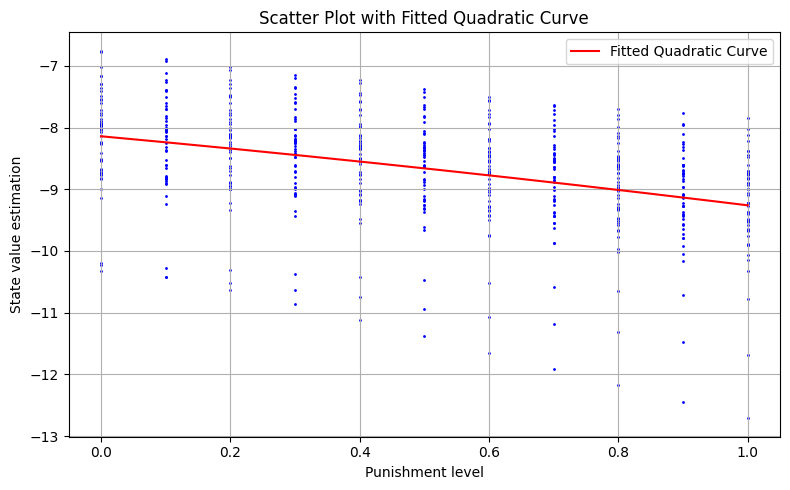

In [32]:
x = probs
y = v_vals_mean

plot_quadratic_curve(x, y, ylabel='State value estimation')

In [29]:
# punishment level ~ voting intention
vote_for_prob = []
vote_against_prob = []
probs = []

for seed in trange(50):
    for prob in np.arange(0, 1.1, 0.1):
        _, _, action_values_lst = run_test(
            seed=seed, 
            clear_world=[], 
            max_turns=1, 
            state_punishment_prob=prob,
            model_prefix=model_name,
            config_path='../configs/config_with_vote_composite_study1_probe_test.yaml',
            algo='iqn',
        )
        action_values_lst = [val[0] for val in action_values_lst]
        vote_for_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 4].mean()
        vote_against_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 5].mean()
        vote_for_prob.append(vote_for_prob_val_mean)
        vote_against_prob.append(vote_against_prob_val_mean)
        probs.append(prob)


  0%|          | 0/50 [00:00<?, ?it/s]

here
here
here
here
here
here
here
here
here
here
here


  2%|▏         | 1/50 [00:03<03:05,  3.79s/it]

here
here
here
here
here
here
here
here
here
here
here


  4%|▍         | 2/50 [00:07<02:49,  3.53s/it]

here
here
here
here
here
here
here
here
here
here
here


  6%|▌         | 3/50 [00:10<02:44,  3.50s/it]

here
here
here
here
here
here
here
here
here
here
here


  8%|▊         | 4/50 [00:13<02:37,  3.43s/it]

here
here
here
here
here
here
here
here
here
here
here


 10%|█         | 5/50 [00:17<02:38,  3.52s/it]

here
here
here
here
here
here
here
here
here
here
here


 12%|█▏        | 6/50 [00:20<02:28,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 14%|█▍        | 7/50 [00:24<02:24,  3.35s/it]

here
here
here
here
here
here
here
here
here
here
here


 16%|█▌        | 8/50 [00:27<02:24,  3.43s/it]

here
here
here
here
here
here
here
here
here
here
here


 18%|█▊        | 9/50 [00:30<02:15,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 20%|██        | 10/50 [00:34<02:15,  3.38s/it]

here
here
here
here
here
here
here
here
here
here
here


 22%|██▏       | 11/50 [00:37<02:07,  3.26s/it]

here
here
here
here
here
here
here
here
here
here
here


 24%|██▍       | 12/50 [00:40<02:07,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 26%|██▌       | 13/50 [00:43<02:01,  3.29s/it]

here
here
here
here
here
here
here
here
here
here
here


 28%|██▊       | 14/50 [00:46<01:55,  3.21s/it]

here
here
here
here
here
here
here
here
here
here
here


 30%|███       | 15/50 [00:49<01:50,  3.16s/it]

here
here
here
here
here
here
here
here
here
here
here


 32%|███▏      | 16/50 [00:53<01:51,  3.29s/it]

here
here
here
here
here
here
here
here
here
here
here


 34%|███▍      | 17/50 [00:56<01:49,  3.32s/it]

here
here
here
here
here
here
here
here
here
here
here


 36%|███▌      | 18/50 [01:00<01:45,  3.30s/it]

here
here
here
here
here
here
here
here
here
here
here


 38%|███▊      | 19/50 [01:03<01:39,  3.22s/it]

here
here
here
here
here
here
here
here
here
here
here


 40%|████      | 20/50 [01:06<01:34,  3.16s/it]

here
here
here
here
here
here
here
here
here
here
here


 42%|████▏     | 21/50 [01:09<01:30,  3.12s/it]

here
here
here
here
here
here
here
here
here
here
here


 44%|████▍     | 22/50 [01:12<01:27,  3.13s/it]

here
here
here
here
here
here
here
here
here
here
here


 46%|████▌     | 23/50 [01:15<01:23,  3.10s/it]

here
here
here
here
here
here
here
here
here
here
here


 48%|████▊     | 24/50 [01:19<01:24,  3.27s/it]

here
here
here
here
here
here
here
here
here
here
here


 50%|█████     | 25/50 [01:22<01:20,  3.20s/it]

here
here
here
here
here
here
here
here
here
here
here


 52%|█████▏    | 26/50 [01:25<01:20,  3.37s/it]

here
here
here
here
here
here
here
here
here
here
here


 54%|█████▍    | 27/50 [01:29<01:15,  3.28s/it]

here
here
here
here
here
here
here
here
here
here
here


 56%|█████▌    | 28/50 [01:31<01:09,  3.17s/it]

here
here
here
here
here
here
here
here
here
here
here


 58%|█████▊    | 29/50 [01:34<01:05,  3.11s/it]

here
here
here
here
here
here
here
here
here
here
here


 60%|██████    | 30/50 [01:38<01:02,  3.14s/it]

here
here
here
here
here
here
here
here
here
here
here


 62%|██████▏   | 31/50 [01:41<00:59,  3.11s/it]

here
here
here
here
here
here
here
here
here
here
here


 64%|██████▍   | 32/50 [01:44<00:57,  3.18s/it]

here
here
here
here
here
here
here
here
here
here
here


 66%|██████▌   | 33/50 [01:47<00:52,  3.11s/it]

here
here
here
here
here
here
here
here
here
here
here


 68%|██████▊   | 34/50 [01:50<00:50,  3.17s/it]

here
here
here
here
here
here
here
here
here
here
here


 70%|███████   | 35/50 [01:53<00:46,  3.13s/it]

here
here
here
here
here
here
here
here
here
here
here


 72%|███████▏  | 36/50 [01:56<00:44,  3.15s/it]

here
here
here
here
here
here
here
here
here
here
here


 74%|███████▍  | 37/50 [01:59<00:40,  3.11s/it]

here
here
here
here
here
here
here
here
here
here
here


 76%|███████▌  | 38/50 [02:03<00:37,  3.15s/it]

here
here
here
here
here
here
here
here
here
here
here


 78%|███████▊  | 39/50 [02:06<00:35,  3.22s/it]

here
here
here
here
here
here
here
here
here
here
here


 80%|████████  | 40/50 [02:10<00:33,  3.33s/it]

here
here
here
here
here
here
here
here
here
here
here


 82%|████████▏ | 41/50 [02:13<00:29,  3.24s/it]

here
here
here
here
here
here
here
here
here
here
here


 84%|████████▍ | 42/50 [02:16<00:25,  3.24s/it]

here
here
here
here
here
here
here
here
here
here
here


 86%|████████▌ | 43/50 [02:19<00:22,  3.28s/it]

here
here
here
here
here
here
here
here
here
here
here


 88%|████████▊ | 44/50 [02:22<00:19,  3.18s/it]

here
here
here
here
here
here
here
here
here
here
here


 90%|█████████ | 45/50 [02:25<00:15,  3.12s/it]

here
here
here
here
here
here
here
here
here
here
here


 92%|█████████▏| 46/50 [02:28<00:12,  3.10s/it]

here
here
here
here
here
here
here
here
here
here
here


 94%|█████████▍| 47/50 [02:32<00:09,  3.15s/it]

here
here
here
here
here
here
here
here
here
here
here


 96%|█████████▌| 48/50 [02:35<00:06,  3.29s/it]

here
here
here
here
here
here
here
here
here
here
here


 98%|█████████▊| 49/50 [02:38<00:03,  3.25s/it]

here
here
here
here
here
here
here
here
here
here
here


100%|██████████| 50/50 [02:42<00:00,  3.25s/it]


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.699
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                              1273.
Date:                Fri, 08 Aug 2025   Prob (F-statistic):                   3.76e-145
Time:                        14:17:14   Log-Likelihood:                          145.47
No. Observations:                 550   AIC:                                     -288.9
Df Residuals:                     549   BIC:                                     -284.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

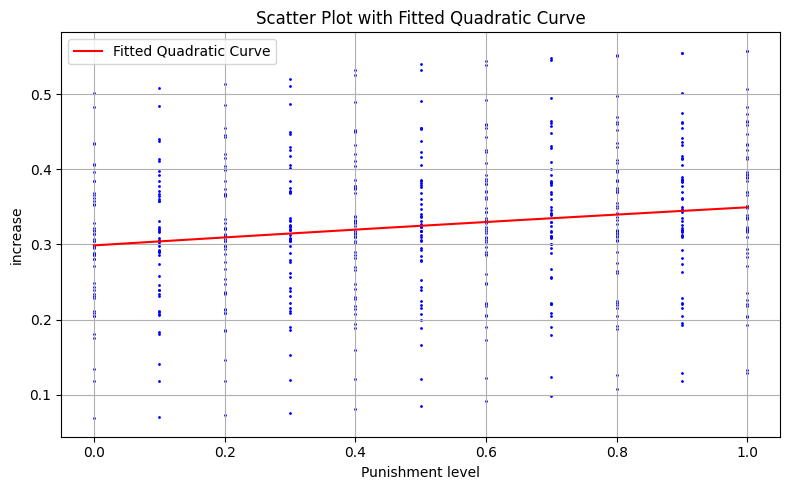

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.704
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                              1307.
Date:                Fri, 08 Aug 2025   Prob (F-statistic):                   2.65e-147
Time:                        14:17:14   Log-Likelihood:                          444.83
No. Observations:                 550   AIC:                                     -887.7
Df Residuals:                     549   BIC:                                     -883.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

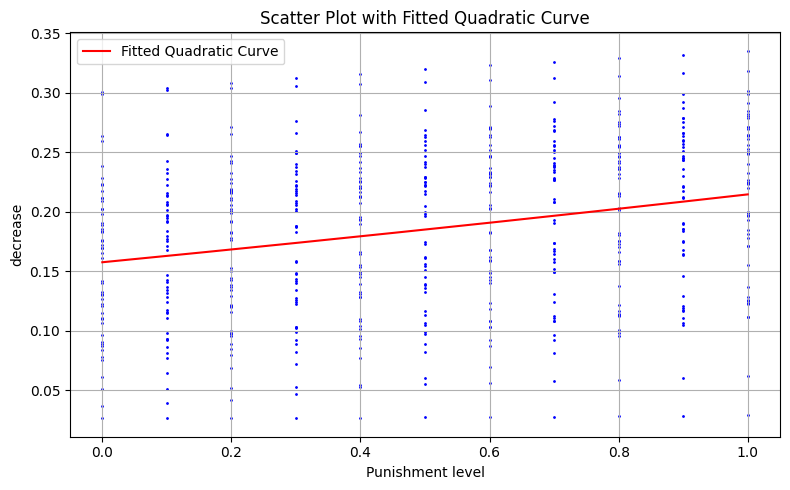

In [30]:
x = probs
y = vote_for_prob
# Fit OLS model
model = sm.OLS(y, x).fit()

# Print summary, includes p-values
print(model.summary())
plot_quadratic_curve(x, y, ylabel='increase')

y = vote_against_prob
# Fit OLS model
model = sm.OLS(y, x).fit()

# Print summary, includes p-values
print(model.summary())
plot_quadratic_curve(x, y, ylabel='decrease')

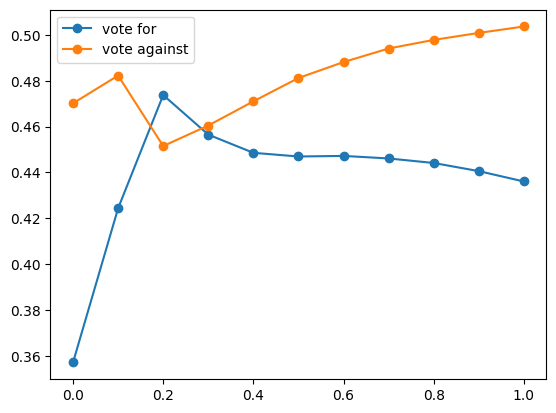

In [ ]:
# punishment level ~ voting intention
vote_for_prob = []
vote_against_prob = []

for prob in np.arange(0, 1.1, 0.1):
    _, _, action_values_lst = run_test(
        clear_world=[], max_turns=1, state_punishment_prob=prob,
        model_prefix=model_name,
        config_path='../configs/config_with_vote_composite_study1_probe_test.yaml'
    )
    action_values_lst = [val[0] for val in action_values_lst]
    vote_for_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 4].mean()
    vote_against_prob_val_mean = softmax(torch.stack(action_values_lst).numpy().squeeze(), axis=-1)[:, 5].mean()
    vote_for_prob.append(vote_for_prob_val_mean)
    vote_against_prob.append(vote_against_prob_val_mean)
plt.plot(np.arange(0, 1.1, 0.1), vote_for_prob, 'o-', label='vote for')
plt.plot(np.arange(0, 1.1, 0.1), vote_against_prob, 'o-', label='vote against')
plt.legend()

In [28]:
vote_for, vote_against = run_test(True)
print('vote for', vote_for)
print('vote against', vote_against)

vote for [1, 30, 16]
vote against [26, 0, 10]


In [29]:
vote_for, vote_against = run_test(False)
print('vote for', vote_for)
print('vote against', vote_against)

vote for [24, 30, 3]
vote against [5, 0, 26]


Visualization

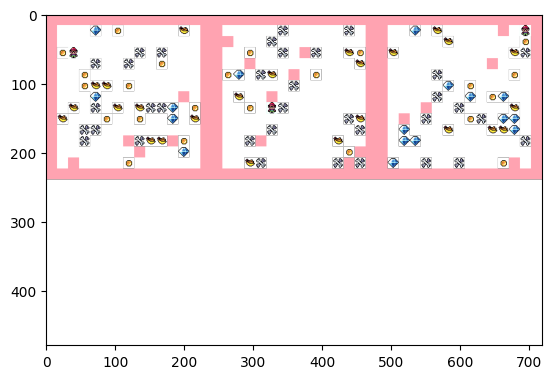

0.1
[0, 0, 0]
punishment level 0
5


KeyboardInterrupt: 

In [33]:
# composite visualization

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_with_vote_composite_study1.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array, composite_visualization
from examples.state_punishment.state_sys import state_sys
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse
from copy import deepcopy
import torch



tile_size = 32
cfg = load_config(argparse.Namespace(config=config_path))
cfg.env.prob.respawn_rate = 0.0
cfg.experiment.max_turns = 30
clear_world = False

# set seed 
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
torch.cuda.manual_seed_all(cfg.seed)

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
envs = []
for i in range(len(agents)):
    envs.append(
        state_punishment(cfg, [agents[i]], deepcopy(entities))
    )


for ixs, agent in enumerate(agents):
    if agent.ixs > -1:
        agent.model.load(
            f'../models/checkpoints/Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_agent{agent.ixs}_iRainbowModel.pkl'
        )
    else:
        agent.model = human_player.ModelHumanPlayer(
            action_space=4, 
            state_size = cfg.model.iqn.parameters.state_size, 
            extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
            memory_size=1, 
            name=f'human {ixs}')


for epoch in range(1):
    # Reset the environment at the start of each epoch
    for env_ixs, env in enumerate(envs):
        env.reset(state_mode='composite')
        if clear_world and env_ixs == 1:
            env.clear_world(keep_agents=True)
        env.cache['harm'] = [0 for _ in range(len(agents))]
    images_anim = []
    # for agent in env.agents:
    #     agent.reset(env)
    random.shuffle(agents)

    scores = GameLogger(max_epochs=1)

   
    fixed_prob_dict = {'Gem': cfg.state_sys.prob_list.Gem,
                        'Coin': cfg.state_sys.prob_list.Coin,
                        'Bone': cfg.state_sys.prob_list.Bone}
    
    # initialize state system
    state_entity = state_sys(
            cfg.state_sys.init_prob, 
            fixed_prob_dict,
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.resource_punishment_is_ambiguous,
            cfg.state_sys.potential_taboo,
            cfg.state_sys.only_punish_taboo,
            cfg = cfg
            )

    env.cache['harm'] = [0 for _ in range(len(agents))]

    done = 0 
    turn = 0
    losses = 0
    game_points = [0 for _ in range(len(agents))]
    vote_for = [0 for _ in range(len(agents))]
    vote_against = [0 for _ in range(len(agents))]

    while not done:

        turn = turn + 1

        for env in envs:
            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

        # img = visual_field_sprite(env.world, tile_size = env.tile_size)
        img = composite_visualization(envs, tile_size = tile_size)
        clear_output(wait = True)
        # scores.pretty_print(
        #      'jupyter-mode',
        #      epoch = epoch,
        #      turn = turn,
        #      reward = game_points,
        # )
        
        img = image_from_array(img)
        time.sleep(0.1)
        plt.imshow(img)
        plt.show()
        images_anim.append(img)
        print(state_entity.prob)
        print(game_points)


        # Agent transition
        for ixs, agent in enumerate(agents):

            (state, action, reward, next_state, done_) = agent.transition(
                    envs[agent.ixs], 
                    state_entity, 
                    'certain', 
                    action_mode=cfg.action_mode,
                    state_is_composite=cfg.state_mode=='composite',
                    envs=envs
                    )
            # record vote
            if action == 4:
                vote_for[agent.ixs] += 1
            elif action == 5:
                vote_against[agent.ixs] += 1

            # update state system
            print('punishment level', state_entity.level)
            if agent.ixs == 0:
                print(action)
            composite_state = agent.generate_composite_state(envs)
            # img = visual_field_sprite(env.world, tile_size = env.tile_size)
            img = composite_visualization(envs, tile_size = tile_size)
            img = image_from_array(img)
            # print(agent.model.name)
            # plt.imshow(img)
            plt.show()
            # if agent.ixs == 0:
            #      images_anim.append(img)

            if turn >= cfg.experiment.max_turns or done_:
                done = 1

            exp = (1, (composite_state, action, reward, next_state, done))
            # agent.episode_memory.append(exp)
            agent.add_memory(state, action, reward, done)

            game_points[agent.ixs] += reward

print('vote for', vote_for)
print('vote against', vote_against)


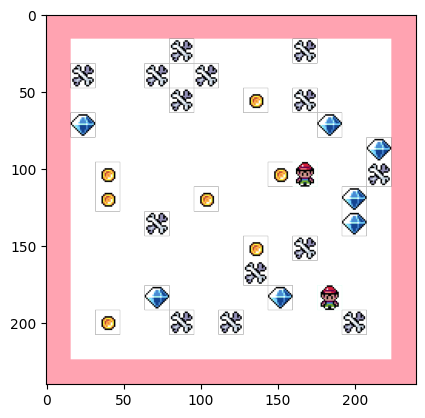

0.0
[5, 10]
Please try again. Possible actions are below.
[0 1 2 3 4 5 6 7]


UnboundLocalError: local variable 'action' referenced before assignment

In [2]:
%load_ext autoreload

# --------------- #
# region: Imports #
import os
import sys
module_path = os.path.abspath('../../..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
# endregion       #
# --------------- #

from examples.state_punishment.utils import (
    init_log, parse_args, load_config,
    create_models,
    create_agents,
    create_entities,
)
config_path = '../configs/config_fixed_rate_no_vote.yaml'
from examples.state_punishment import agents, entities
from examples.state_punishment.env import state_punishment
from examples.state_punishment.utils import inspect_the_env
from agentarium.logging_utils import GameLogger
from agentarium.models import human_player
from agentarium.utils import visual_field_sprite, image_from_array
from examples.state_punishment.state_sys import state_sys, Monitor
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random
import argparse

cfg = load_config(argparse.Namespace(config=config_path))

models = create_models(cfg)
agents = create_agents(cfg, models)
entities = create_entities(cfg)
env = state_punishment(cfg, agents, entities)


for ixs, agent in enumerate(agents):
    agent.model = human_player.ModelHumanPlayer(
         action_space=8, 
         state_size = cfg.model.iqn.parameters.state_size, 
         extra_percept_size = cfg.model.iqn.parameters.extra_percept_size,
         memory_size=1, 
         name=f'human {ixs}')
    # agent.model.load(
    #      f'../models/checkpoints/fixed_punishment_rate_0.75_twoAs_extra_percept_v2_higher_harm_gem_has_value_save_model_agent{ixs}_iRainbowModel_20241127-04111732699956.pkl')
    # agent.model.load(
    #      '../models/checkpoints/fixed_punishment_rate_1.0_oneAs_size15_init_spawn_0.2_agent0_iRainbowModel.pkl'
    # )
    # agent.model.epsilon = 0.01


for epoch in range(1):
    # Reset the environment at the start of each epoch
        env.reset()
        images_anim = []
        # for agent in env.agents:
        #     agent.reset(env)
        random.shuffle(agents)

        scores = GameLogger(max_epochs=1)

        cfg.state_sys.prob_list = {'Gem': cfg.state_sys.prob_list.Gem,
                                   'Coin': cfg.state_sys.prob_list.Coin,
                                   'Bone': cfg.state_sys.prob_list.Bone}
        # initialize state system
        state_entity = state_sys(
            cfg.state_sys.init_prob, 
            cfg.state_sys.prob_list, 
            cfg.state_sys.magnitude, 
            cfg.state_sys.taboo,
            cfg.state_sys.change_per_vote
            )
        print(state_entity.prob_list)
        
        monitor = Monitor(2, ['gem'], 15) # initiate monitor
        
        env.cache['harm'] = [0 for _ in range(len(agents))]

        done = 0 
        turn = 0
        losses = 0
        game_points = [0 for _ in range(len(agents))]

        while not done:

            turn = turn + 1

            entities = env.get_entities_for_transition()
            # Entity transition
            for entity in entities:
                entity.transition(env)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            # scores.pretty_print(
            #      'jupyter-mode',
            #      epoch = epoch,
            #      turn = turn,
            #      reward = game_points,
            # )
            
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()
            images_anim.append(img)
            print(state_entity.prob)
            print(game_points)

            # update the record of the monitor
            if monitor.time == 0:
                new_data = monitor.collect_new_state_info(env, types=None, turn=monitor.time, done=done) ##
                
                monitor.time_of_next_check()
                monitor.update(new_data) ##
                print(monitor.wait_time, monitor.check_time)
            # Agent transition
            for agent in agents:

                (state,
                action,
                reward,
                next_state,
                done_
                ) = agent.transition(env, state_entity)

                img = visual_field_sprite(env.world, tile_size = env.tile_size)
                img = image_from_array(img)
                # print(agent.model.name)
                # plt.imshow(img)
                plt.show()
                # if agent.ixs == 0:
                #      images_anim.append(img)

                if turn >= cfg.experiment.max_turns or done_:
                    done = 1

                exp = (1, (state, action, reward, next_state, done))
                # agent.episode_memory.append(exp)

                game_points[agent.ixs] += reward

                print(agent.location)

            img = visual_field_sprite(env.world, tile_size = env.tile_size)
            clear_output(wait = True)
            img = image_from_array(img)
            time.sleep(0.1)
            plt.imshow(img)
            plt.show()

            # regular check all resources being monitored
            
            monitor.time += 1
            print(monitor.time, monitor.check_time)
            new_data = monitor.collect_new_state_info(env, types=None, turn=monitor.time, done=done) ##
            monitor.update(new_data) ##
            monitor.regular_check_all_resources(turn, state_entity, agents) ##
            monitor.time_of_next_check()
            # monitor.time_of_next_check() ##

In [ ]:
for index, _ in np.ndenumerate(env.world[:, :, 0]):
    H, W = index  # Get the coordinates
    # Return visualization image
    print(type(env.world[H, W, 0]), env.world[H, W, 0].appearance)

In [5]:
from PIL import Image
import imageio.v3 as iio
def create_gif_from_arrays(image_arrays, output_path, duration=100, loop=0):
    """
    Create a GIF from a sequence of images in NumPy array format.

    Args:
        image_arrays (list of np.ndarray): Sequence of images as NumPy arrays.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
    """
    # Convert NumPy arrays to PIL Images
    if type(image_arrays[0]) != Image.Image:
        pil_images = [Image.fromarray(img) for img in image_arrays]
    else:
        pil_images = image_arrays
    
    # Save as GIF
    pil_images[0].save(
        output_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


def create_gif_iio(images, output_path, fps=10):
    """
    Create a GIF from a list of image arrays using `imageio`.

    Args:
        images (list of numpy.ndarray): A list of image arrays (e.g., RGB or grayscale).
        output_path (str): Path to save the generated GIF.
        fps (int): Frames per second, controlling the speed of the GIF.
    """
    # Calculate the duration per frame in seconds
    duration_per_frame = 1 / fps
    
    # Save the GIF
    iio.imwrite(output_path, images, format="GIF", duration=duration_per_frame)
    print(f"GIF saved at {output_path}")


from PIL import Image, ImageDraw

from PIL import Image

def create_gif_from_pil_force_clean(image_list, output_path, duration=100, loop=0, background_color=(255, 255, 255)):
    """
    Create a GIF from a list of `PIL.Image.Image` objects, ensuring no shadow artifacts.
    Ensures each frame has a fresh background.

    Args:
        image_list (list of PIL.Image.Image): Sequence of PIL images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration of each frame in milliseconds (controls speed).
        loop (int): Number of times the GIF should loop (0 for infinite).
        background_color (tuple): RGB color to reset the background for each frame.
    """
    # Determine the size of the images
    width, height = image_list[0].size

    # Ensure all frames are re-rendered on a clean background
    cleaned_frames = []
    for img in image_list:
        # Create a blank canvas for each frame
        blank_frame = Image.new(mode=img.mode, size=(width, height), color=background_color)
        
        # Convert the image to RGBA to handle transparency (if needed)
        if img.mode != "RGBA":
            img = img.convert("RGBA")
        
        # Paste the current frame onto the blank canvas
        blank_frame.paste(img, (0, 0), mask=img if img.mode == "RGBA" else None)
        cleaned_frames.append(blank_frame)

    # Save as GIF
    cleaned_frames[0].save(
        output_path,
        save_all=True,
        append_images=cleaned_frames[1:],
        duration=duration,
        loop=loop
    )
    print(f"GIF saved at {output_path}")


In [6]:
# from examples.state_punishment.utils import create_gif_from_arrays
print(type(images_anim[0]) == Image.Image)
create_gif_from_pil_force_clean(images_anim, 'test_parallel_envs.gif', 200)


True
GIF saved at test_parallel_envs.gif
